In [15]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.interpolate import interp1d

def extract_numbers(filename):
    """파일 이름에서 실험 번호와 샘플 번호를 추출합니다.

    Args:
        filename (str): 파일 이름 (예: 'T1_1_Expt_1_2.csv')

    Returns:
        tuple: 추출된 숫자들 (T 번호, 샘플 번호, 실험 번호)을 반환합니다.
        None: 파일 이름이 형식에 맞지 않으면 None을 반환합니다.
    """
    match = re.match(r'T(\d+)_(\d+)_Expt_(\d+)_(\d+).csv', filename)
    if match:
        T, S, E, _ = map(int, match.groups())
        return T, S, E
    print('No match')
    return None

def combine_data(dir_path, Tnum, sensor='Accelerometer'):
    """주어진 디렉토리에서 특정 센서 데이터를 통합하여 DataFrame으로 반환합니다.

    Args:
        dir_path (str): 데이터 파일이 저장된 디렉토리 경로
        Tnum (str): 실험 번호 디렉토리 (예: 'T1')
        sensor (str): 센서 유형 (예: 'Accelerometer', 기본값: 'Accelerometer')

    Returns:
        pandas.DataFrame: 통합된 센서 데이터
    """
    dfs = []
    path = os.path.join(dir_path, Tnum, sensor)
    if os.path.exists(path):
        sorted_files = sorted(os.listdir(path), key=lambda x: extract_numbers(x))
        for file in sorted_files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(path, file))
                _, S, E = extract_numbers(file)
                df['sample'] = S
                df['Expt'] = E
                dfs.append(df)
    else:
        print(f'{path} not found')
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def downsampling(ACC, FOR):
    """가속도계 데이터를 힘 센서 데이터의 크기와 맞추기 위해 다운샘플링합니다.

    Args:
        ACC (pandas.DataFrame): 가속도계 데이터
        FOR (pandas.DataFrame): 힘 센서 데이터

    Returns:
        pandas.DataFrame: 다운샘플링된 가속도계 데이터
    """
    dfs = []
    sample_max = int(FOR.iloc[-1]['sample'])  # 힘 센서 데이터의 최대 샘플 수

    for s in range(1, sample_max + 1):
        sample_acc = ACC[ACC['sample'] == s]
        sample_for = FOR[FOR['sample'] == s]

        len_acc = len(sample_acc)
        len_for = len(sample_for)
        x = np.linspace(0, 1, len_acc)
        x_new = np.linspace(0, 1, len_for)

        sample_acc = sample_acc.drop(columns=['sample', 'Expt'])
        df = pd.DataFrame({col: np.interp(x_new, x, sample_acc[col]) for col in sample_acc.columns})
        dfs.append(df)

    ACC_interp = pd.concat(dfs, ignore_index=True)
    return ACC_interp

def health_index(scores, th, increase_step=1, decrease_step=0.1):
    """점수에 기반하여 헬스 지수를 계산합니다.

    Args:
        scores (list): 입력 점수 목록
        th (float): 임계값
        increase_step (float): 점수가 임계값을 초과할 때 증가하는 단계 크기
        decrease_step (float): 점수가 임계값 이하일 때 감소하는 단계 크기

    Returns:
        list: 계산된 헬스 지수 목록
    """
    state = 0
    state_values = []
    for score in scores:
        if score > th:
            state += increase_step
        else:
            state = max(0, state - decrease_step)
        state_values.append(state)
    return state_values

# 데이터 경로 설정
dir_path = 'data/splitted_100ms'

# 모델 및 스케일러 로드
loaded_model = joblib.load('weights/isolation_forest_model.pkl')
print('Model loaded.')
loaded_scaler = joblib.load('weights/scaler_mscred.pkl')
print('Scaler loaded.')


Model loaded.
Scaler loaded.


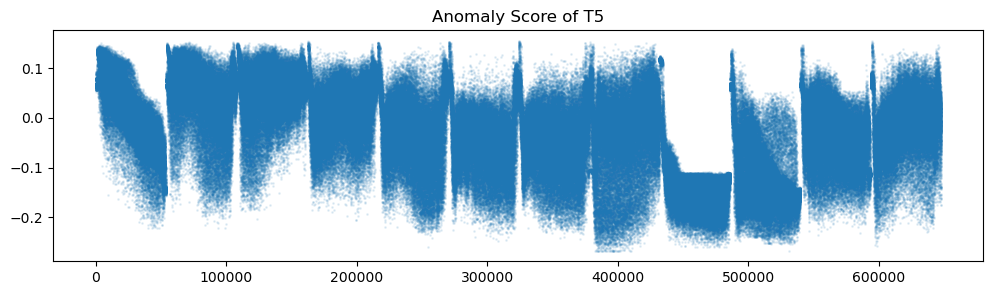

In [16]:
Tnum = 'T5'

Tx_acc = combine_data(dir_path, Tnum=Tnum, sensor='Accelerometer')
Tx_for = combine_data(dir_path, Tnum=Tnum, sensor='Force')

Tx_acc_interp = downsampling(Tx_acc, Tx_for)
Tx_for = Tx_for.drop(columns=['sample'])
Tx = pd.concat([Tx_acc_interp, Tx_for], axis=1)

scores = loaded_model.decision_function(loaded_scaler.transform(Tx.drop(columns=['Expt']).to_numpy()))

plt.figure(figsize=(12, 3))
plt.scatter(range(len(scores)), scores, s=1, alpha=0.1)
plt.title(f'Anomaly Score of T5')
plt.show()

In [17]:
scores_t5 = scores

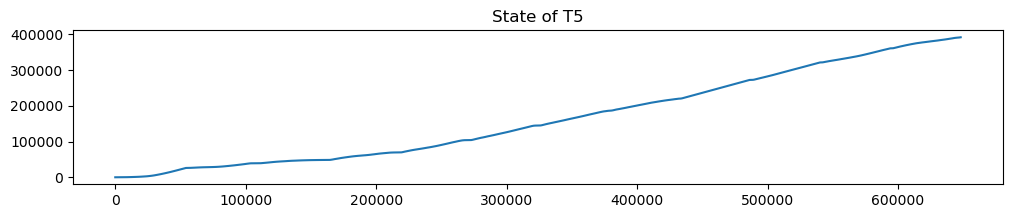

In [18]:
# Anomaly score -> Health index (state)
state_t5 = health_index(-scores_t5, th=0, increase_step=1, decrease_step=0.001)

plt.figure(figsize=(12, 2))
plt.plot(state_t5)
plt.title(f'State of T5')
plt.show()

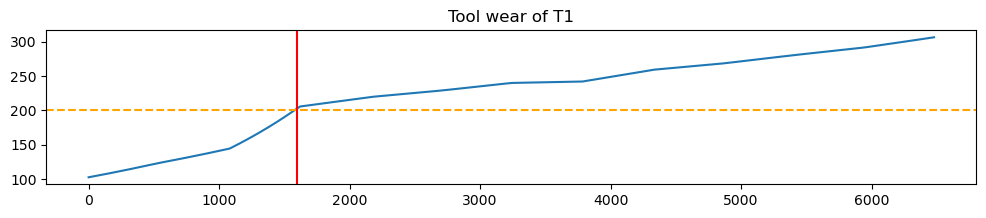

In [19]:
Tnum = 'T1'
toolwear_df = pd.read_csv(os.path.join(dir_path, Tnum, f'{Tnum}_all_labels.csv'))

plt.figure(figsize=(12, 2))
plt.plot(toolwear_df['Tool Wear in (µm)'].values)
plt.axhline(y=200, linestyle='--', c='orange')
plt.axvline(x=1600, c='red')  # threshold 설정 index
plt.title('Tool wear of T1')
plt.show()

In [20]:
# threshold 설정
threshold = state_t5[1600*100]
threshold

48395.327000180725

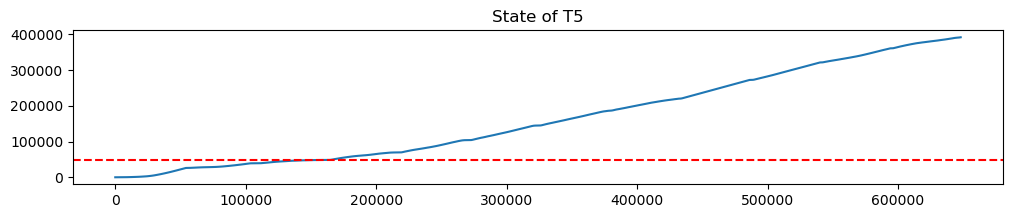

In [21]:
plt.figure(figsize=(12, 2))
plt.plot(state_t5)
plt.axhline(y=threshold, linestyle='--', c='red')
plt.title(f'State of T5')
plt.show()

In [22]:
predicted_labels = np.where(np.array(state_t5)>threshold, 1, 0)
predicted_labels  # 예측 라벨

array([0, 0, 0, ..., 1, 1, 1])

In [23]:
Tnum = 'T5'
toolwear_df = pd.read_csv(os.path.join(dir_path, Tnum, f'{Tnum}_all_labels.csv'))
toolwear_df

,expt_index,Tool Wear in (µm),Label
0,expt1_1,135.460000,normal
1,expt1_2,135.477276,normal
2,expt1_3,135.494554,normal
3,expt1_4,135.511834,normal
4,expt1_5,135.529116,normal
...,...,...,...
6475,expt12_536,308.769586,anomaly
6476,expt12_537,308.799685,anomaly
6477,expt12_538,308.829787,anomaly
6478,expt12_539,308.859892,anomaly


In [24]:
index = toolwear_df.index
toolwear = toolwear_df['Tool Wear in (µm)'].values

f_nearest = interp1d(index, toolwear, kind='nearest')

index_new = np.linspace(index.min(), index.max(), len(scores_t5))
toolwear_new = f_nearest(index_new)

print(len(toolwear))
print(len(toolwear_new))

6480
648000


In [25]:
# tool wear 값 250 이상이면 anomaly
labels = np.where(toolwear_new>=250, 1, 0)
labels  # 실제 라벨

array([0, 0, 0, ..., 1, 1, 1])

In [26]:
# 평가 지표 계산
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
conf_matrix = confusion_matrix(labels, predicted_labels)

# 결과 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.48
Precision: 0.31
Recall: 1.00
F1-Score: 0.47
Confusion Matrix:
[[159997 336129]
 [     0 151874]]
